In [5]:
import numpy as np
import matplotlib.pyplot as plt
from nptdms import TdmsFile
import pandas as pd

In [6]:
file_path = '../data/compliance.tdms'

tdms = TdmsFile.read(file_path)

print("✅ Available groups and channels:")
group_channel_map = {}
for grp in tdms.groups():
    name = grp.name
    channels = [ch.name for ch in grp.channels()]
    group_channel_map[name] = channels
    print(f" - Group: {name}")
    for ch in channels:
        print(f"    • {ch}")

✅ Available groups and channels:
 - Group: Datas
    • Time (ms)
    • Reference Position X
    • Reference Position Y
    • Measured Position X
    • Measured Position Y
    • Reference Tension L
    • Reference Tension R
    • Reference Tension T
    • Measured Tension L
    • Measured Tension R
    • Measured Tension T
    • RBF1
    • RBF2
    • RBF3
    • RBF4
    • RBF5
    • Trajectory
    • Projected Force
    • Force X
    • Force Y
    • Damp1
    • Damp2
    • Damp3
    • Damp4
    • Damp5
    • Manual Trigger


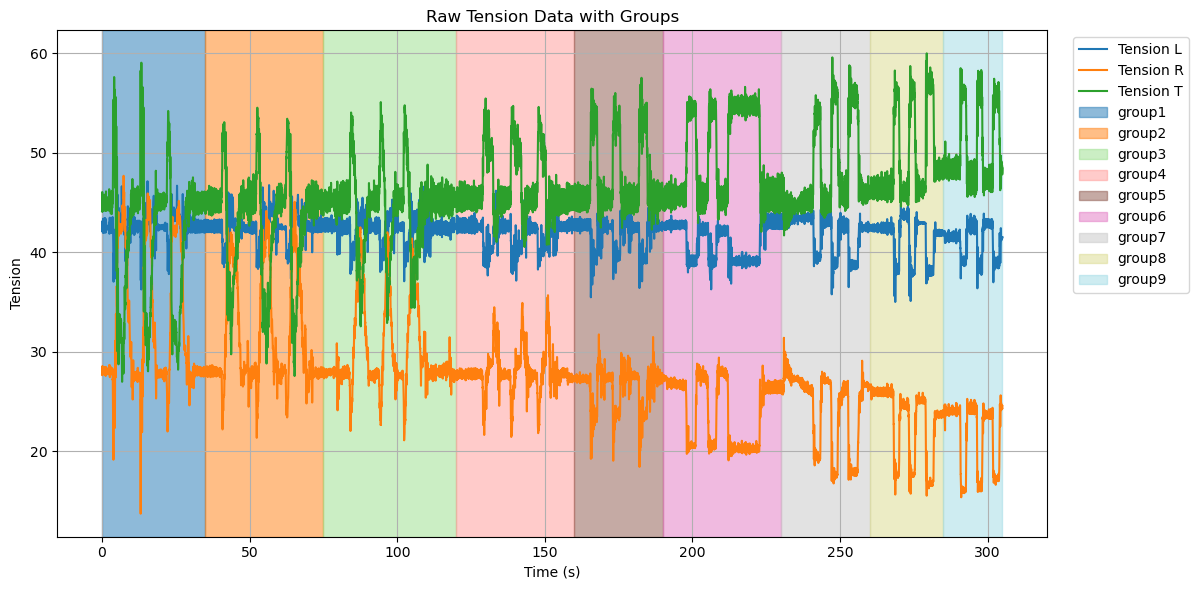

In [7]:
import matplotlib.pyplot as plt
import numpy as np

df = tdms['Datas'].as_dataframe()

sample_rate = 50
time = np.arange(len(df)) / sample_rate
mask_upto = (time <= 305)
df = df.loc[mask_upto].reset_index(drop=True)
time = time[mask_upto]

split_times = [35, 75, 120, 160, 190, 230, 260, 285]
group_data = {}
start_time = 0
group_names = []

for idx, end_time in enumerate(split_times):
    mask = (time >= start_time) & (time < end_time)
    group_name = f'group{idx+1}'
    group_data[group_name] = df[mask]
    group_names.append((start_time, end_time, group_name))
    start_time = end_time

if start_time < time[-1]:
    group_name = f'group{len(split_times)+1}'
    mask = (time >= start_time)
    group_data[group_name] = df[mask]
    group_names.append((start_time, time[-1], group_name))

# ---- 여기부터 색깔 다르게 ----
colors = plt.colormaps['tab20'].resampled(len(group_names))

plt.figure(figsize=(12,6))
plt.plot(time, df['Measured Tension L'], label='Tension L')
plt.plot(time, df['Measured Tension R'], label='Tension R')
plt.plot(time, df['Measured Tension T'], label='Tension T')

for i, (start, end, name) in enumerate(group_names):
    plt.axvspan(start, end, color=colors(i), alpha=0.5, label=name)

plt.title('Raw Tension Data with Groups')
plt.xlabel('Time (s)')
plt.ylabel('Tension')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

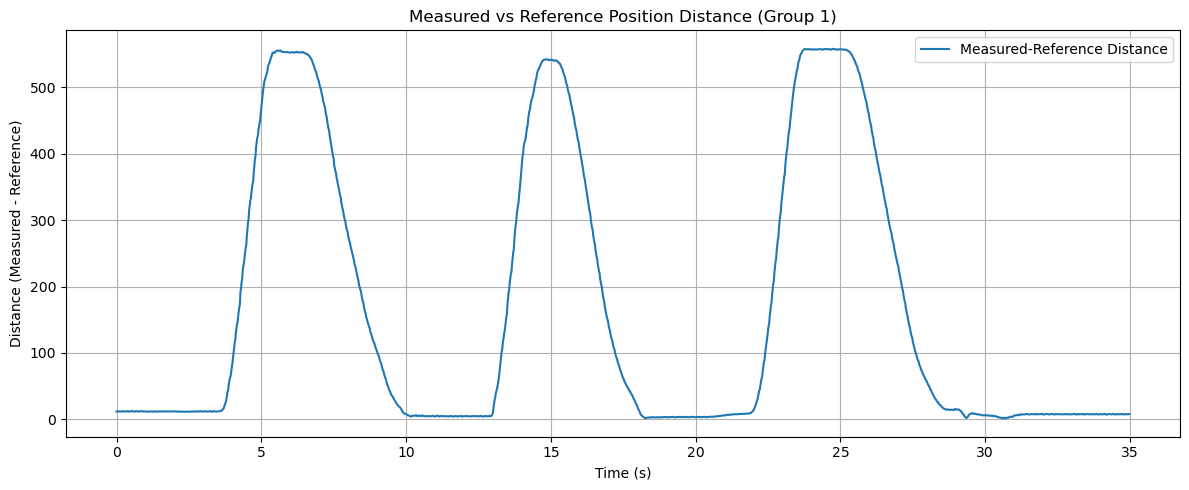

In [8]:
import numpy as np
import matplotlib.pyplot as plt

df_g1 = group_data['group1']
ref_x = df_g1['Reference Position X'].values
ref_y = df_g1['Reference Position Y'].values
act_x = df_g1['Measured Position X'].values
act_y = df_g1['Measured Position Y'].values
sample_rate = 50
time = np.arange(len(df_g1)) / sample_rate

# 각 시점에서 (Reference, Measured) 거리
distance = np.sqrt((act_x - ref_x)**2 + (act_y - ref_y)**2)

plt.figure(figsize=(12,5))
plt.plot(time, distance, label='Measured-Reference Distance')
plt.xlabel('Time (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Measured vs Reference Position Distance (Group 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


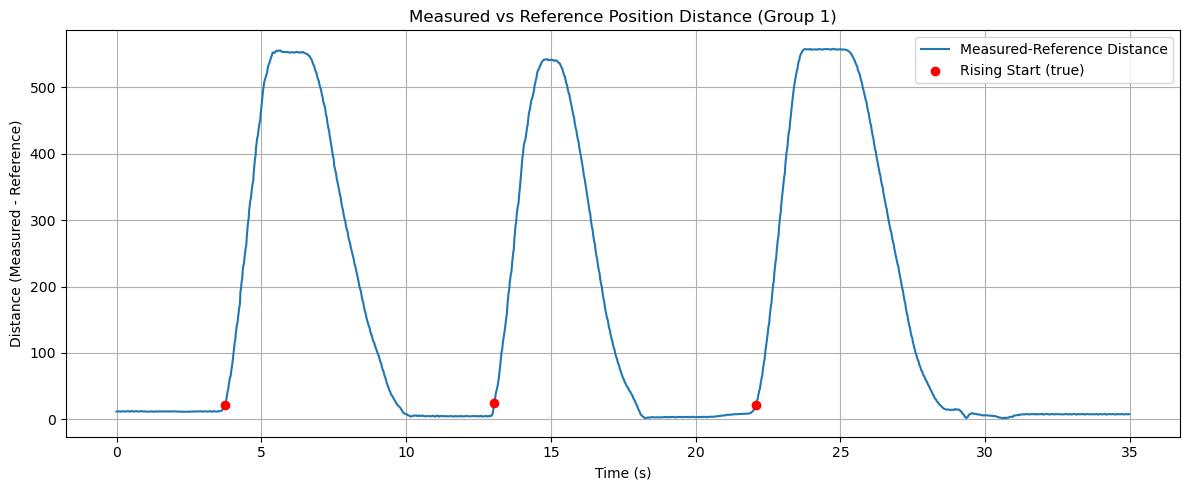

In [9]:
import numpy as np
import matplotlib.pyplot as plt

df_g1 = group_data['group1']
ref_x = df_g1['Reference Position X'].values
ref_y = df_g1['Reference Position Y'].values
act_x = df_g1['Measured Position X'].values
act_y = df_g1['Measured Position Y'].values
sample_rate = 50
time = np.arange(len(df_g1)) / sample_rate

distance = np.sqrt((act_x - ref_x)**2 + (act_y - ref_y)**2)

# 1. 기준선(임계값) crossing 방식: 예를 들어 distance > 50이 되는 순간
threshold = 20
logic = distance > threshold

# rising edge 찾기: False→True가 되는 순간의 인덱스
rising_starts = np.where((~logic[:-1]) & (logic[1:]))[0] + 1

# 충분히 떨어진 시작점만 유지 (너무 가까운 연속 구간 필터링)
min_gap = sample_rate * 5  # 최소 4초 이상 간격
rising_start_filtered = [rising_starts[0]]
for idx in rising_starts[1:]:
    if idx - rising_start_filtered[-1] > min_gap:
        rising_start_filtered.append(idx)
rising_start_filtered = np.array(rising_start_filtered)[:3]  # 3개만

plt.figure(figsize=(12,5))
plt.plot(time, distance, label='Measured-Reference Distance')
plt.scatter(time[rising_start_filtered], distance[rising_start_filtered], color='red', zorder=5, label='Rising Start (true)')
plt.xlabel('Time (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Measured vs Reference Position Distance (Group 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


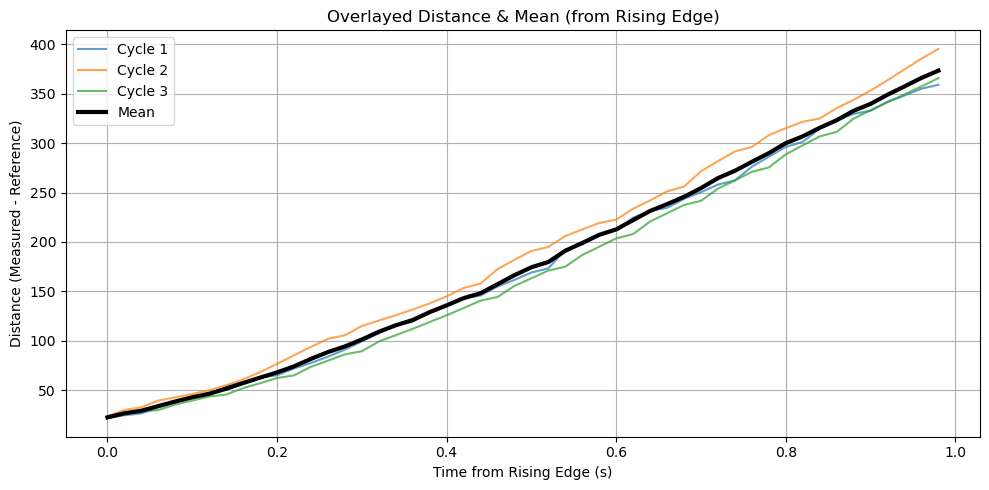

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- 파라미터: 보여줄 구간 (초 단위로 원하는 만큼) ---
window_sec = 1.  # 예: 6초간 보여주기 (여기만 바꾸세요!)
window_len = int(window_sec * sample_rate)

# --- 빨간 점(rising start)에서부터 구간 잘라서 저장 ---
stacked = []
for start in rising_start_filtered:
    if start + window_len <= len(distance):
        stacked.append(distance[start : start + window_len])
stacked = np.array(stacked)  # (사이클 수, window 길이)

# --- 평균 곡선 ---
mean_curve = np.mean(stacked, axis=0)
time_aligned = np.arange(window_len) / sample_rate

# --- 플롯 ---
plt.figure(figsize=(10,5))
for i, cycle in enumerate(stacked, 1):
    plt.plot(time_aligned, cycle, alpha=0.7, label=f'Cycle {i}')
plt.plot(time_aligned, mean_curve, color='k', linewidth=3, label='Mean', zorder=10)
plt.xlabel('Time from Rising Edge (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Overlayed Distance & Mean (from Rising Edge)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
from scipy.stats import linregress

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        y = distance[start : start+window_len]
        t = np.arange(window_len) / sample_rate  # 시간축
        slope, intercept, r_value, p_value, std_err = linregress(t, y)
        print(f"Cycle {i+1} | 기울기 = {slope:.5f} m/s (R²={r_value**2:.3f})")


Cycle 1 | 기울기 = 364.68066 m/s (R²=0.993)
Cycle 2 | 기울기 = 384.48649 m/s (R²=0.994)
Cycle 3 | 기울기 = 364.67045 m/s (R²=0.988)


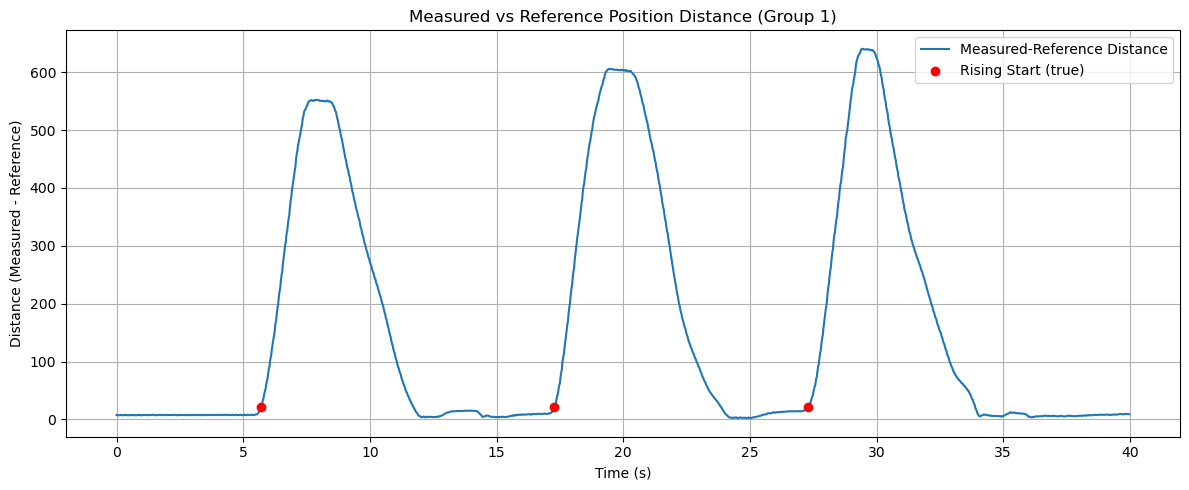

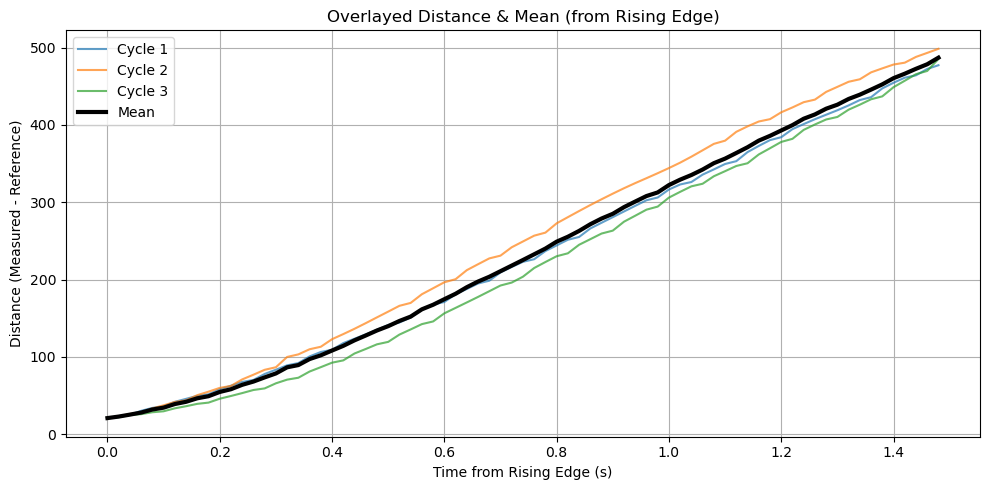

In [12]:
import numpy as np
import matplotlib.pyplot as plt

df_g1 = group_data['group2']
ref_x = df_g1['Reference Position X'].values
ref_y = df_g1['Reference Position Y'].values
act_x = df_g1['Measured Position X'].values
act_y = df_g1['Measured Position Y'].values
sample_rate = 50
time = np.arange(len(df_g1)) / sample_rate

distance = np.sqrt((act_x - ref_x)**2 + (act_y - ref_y)**2)

# 1. 기준선(임계값) crossing 방식: 예를 들어 distance > 50이 되는 순간
threshold = 20
logic = distance > threshold

# rising edge 찾기: False→True가 되는 순간의 인덱스
rising_starts = np.where((~logic[:-1]) & (logic[1:]))[0] + 1

# 충분히 떨어진 시작점만 유지 (너무 가까운 연속 구간 필터링)
min_gap = sample_rate * 5  # 최소 4초 이상 간격
rising_start_filtered = [rising_starts[0]]
for idx in rising_starts[1:]:
    if idx - rising_start_filtered[-1] > min_gap:
        rising_start_filtered.append(idx)
rising_start_filtered = np.array(rising_start_filtered)[:3]  # 3개만

plt.figure(figsize=(12,5))
plt.plot(time, distance, label='Measured-Reference Distance')
plt.scatter(time[rising_start_filtered], distance[rising_start_filtered], color='red', zorder=5, label='Rising Start (true)')
plt.xlabel('Time (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Measured vs Reference Position Distance (Group 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# --- 파라미터: 보여줄 구간 (초 단위로 원하는 만큼) ---
window_sec = 1.5  # 예: 6초간 보여주기 (여기만 바꾸세요!)
window_len = int(window_sec * sample_rate)

# --- 빨간 점(rising start)에서부터 구간 잘라서 저장 ---
stacked = []
for start in rising_start_filtered:
    if start + window_len <= len(distance):
        stacked.append(distance[start : start + window_len])
stacked = np.array(stacked)  # (사이클 수, window 길이)

# --- 평균 곡선 ---
mean_curve = np.mean(stacked, axis=0)
time_aligned = np.arange(window_len) / sample_rate

# --- 플롯 ---
plt.figure(figsize=(10,5))
for i, cycle in enumerate(stacked, 1):
    plt.plot(time_aligned, cycle, alpha=0.7, label=f'Cycle {i}')
plt.plot(time_aligned, mean_curve, color='k', linewidth=3, label='Mean', zorder=10)
plt.xlabel('Time from Rising Edge (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Overlayed Distance & Mean (from Rising Edge)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from scipy.stats import linregress

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        y = distance[start : start+window_len]
        t = np.arange(window_len) / sample_rate  # 시간축
        slope, intercept, r_value, p_value, std_err = linregress(t, y)
        print(f"Cycle {i+1} | 기울기 = {slope:.5f} m/s (R²={r_value**2:.3f})")


Cycle 1 | 기울기 = 325.27542 m/s (R²=0.995)
Cycle 2 | 기울기 = 347.53362 m/s (R²=0.997)
Cycle 3 | 기울기 = 330.09800 m/s (R²=0.989)


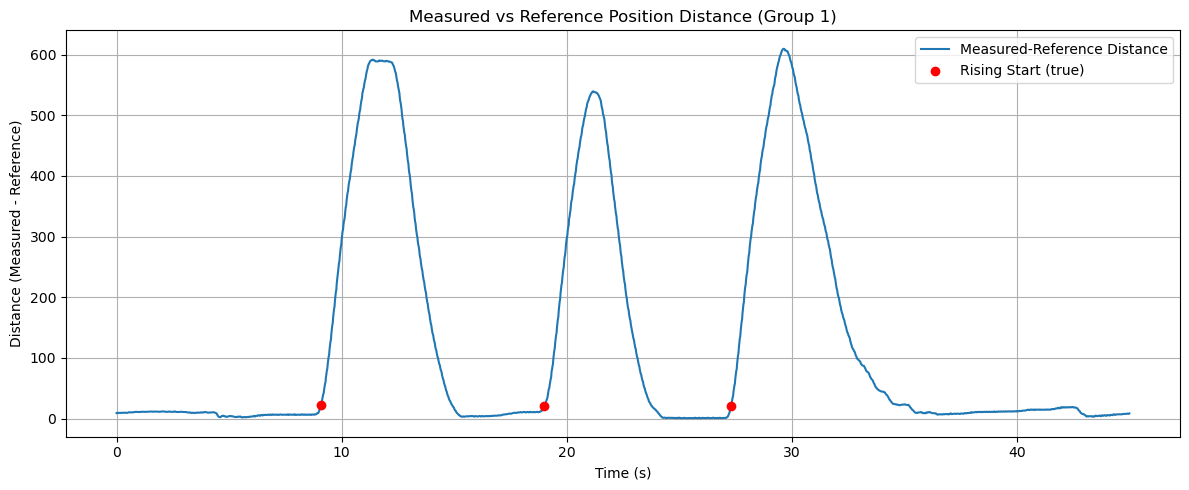

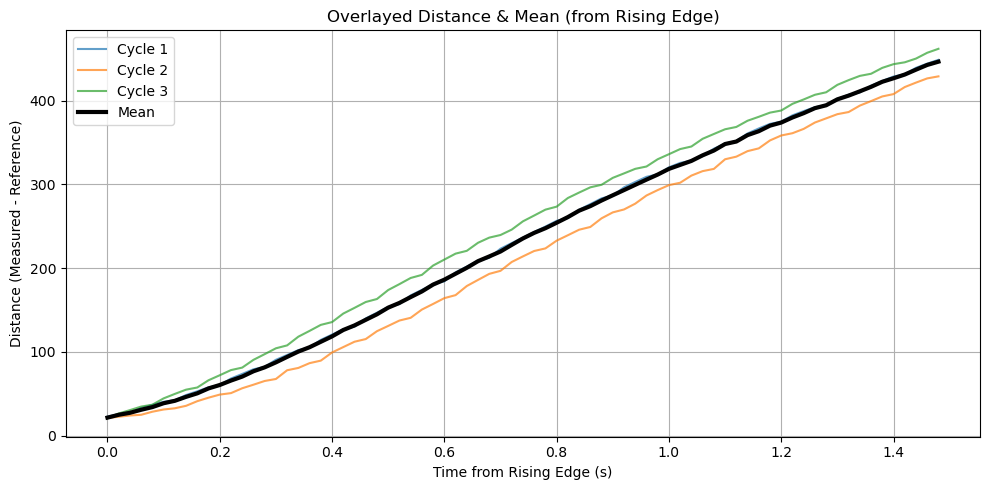

In [14]:
import numpy as np
import matplotlib.pyplot as plt

df_g1 = group_data['group3']
ref_x = df_g1['Reference Position X'].values
ref_y = df_g1['Reference Position Y'].values
act_x = df_g1['Measured Position X'].values
act_y = df_g1['Measured Position Y'].values
sample_rate = 50
time = np.arange(len(df_g1)) / sample_rate

distance = np.sqrt((act_x - ref_x)**2 + (act_y - ref_y)**2)

# 1. 기준선(임계값) crossing 방식: 예를 들어 distance > 50이 되는 순간
threshold = 20
logic = distance > threshold

# rising edge 찾기: False→True가 되는 순간의 인덱스
rising_starts = np.where((~logic[:-1]) & (logic[1:]))[0] + 1

# 충분히 떨어진 시작점만 유지 (너무 가까운 연속 구간 필터링)
min_gap = sample_rate * 5  # 최소 4초 이상 간격
rising_start_filtered = [rising_starts[0]]
for idx in rising_starts[1:]:
    if idx - rising_start_filtered[-1] > min_gap:
        rising_start_filtered.append(idx)
rising_start_filtered = np.array(rising_start_filtered)[:3]  # 3개만

plt.figure(figsize=(12,5))
plt.plot(time, distance, label='Measured-Reference Distance')
plt.scatter(time[rising_start_filtered], distance[rising_start_filtered], color='red', zorder=5, label='Rising Start (true)')
plt.xlabel('Time (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Measured vs Reference Position Distance (Group 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# --- 파라미터: 보여줄 구간 (초 단위로 원하는 만큼) ---
window_sec = 1.5  # 예: 6초간 보여주기 (여기만 바꾸세요!)
window_len = int(window_sec * sample_rate)

# --- 빨간 점(rising start)에서부터 구간 잘라서 저장 ---
stacked = []
for start in rising_start_filtered:
    if start + window_len <= len(distance):
        stacked.append(distance[start : start + window_len])
stacked = np.array(stacked)  # (사이클 수, window 길이)

# --- 평균 곡선 ---
mean_curve = np.mean(stacked, axis=0)
time_aligned = np.arange(window_len) / sample_rate

# --- 플롯 ---
plt.figure(figsize=(10,5))
for i, cycle in enumerate(stacked, 1):
    plt.plot(time_aligned, cycle, alpha=0.7, label=f'Cycle {i}')
plt.plot(time_aligned, mean_curve, color='k', linewidth=3, label='Mean', zorder=10)
plt.xlabel('Time from Rising Edge (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Overlayed Distance & Mean (from Rising Edge)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
from scipy.stats import linregress

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        y = distance[start : start+window_len]
        t = np.arange(window_len) / sample_rate  # 시간축
        slope, intercept, r_value, p_value, std_err = linregress(t, y)
        print(f"Cycle {i+1} | 기울기 = {slope:.5f} m/s (R²={r_value**2:.3f})")


Cycle 1 | 기울기 = 306.44276 m/s (R²=0.998)
Cycle 2 | 기울기 = 301.23562 m/s (R²=0.995)
Cycle 3 | 기울기 = 311.78810 m/s (R²=0.997)


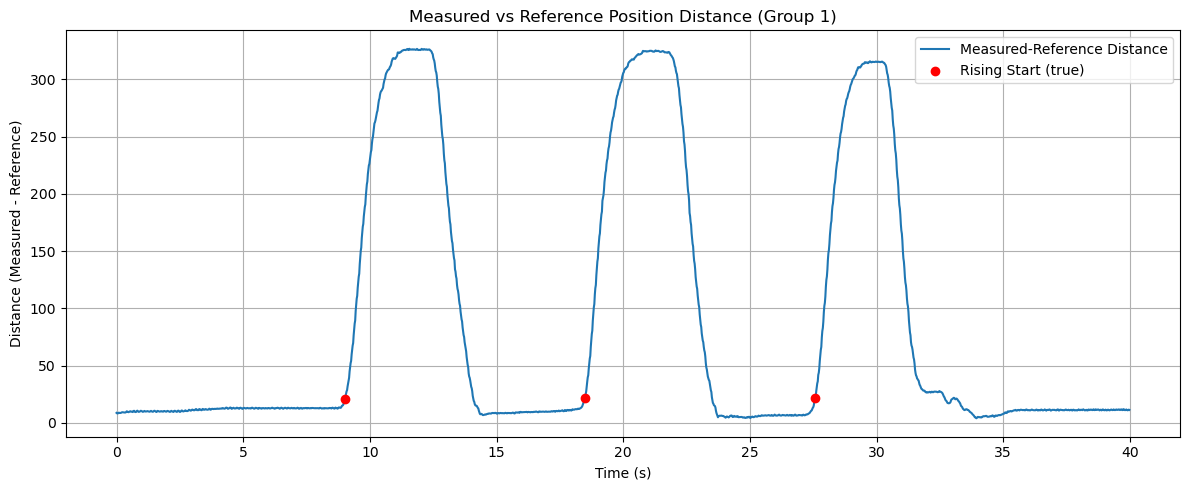

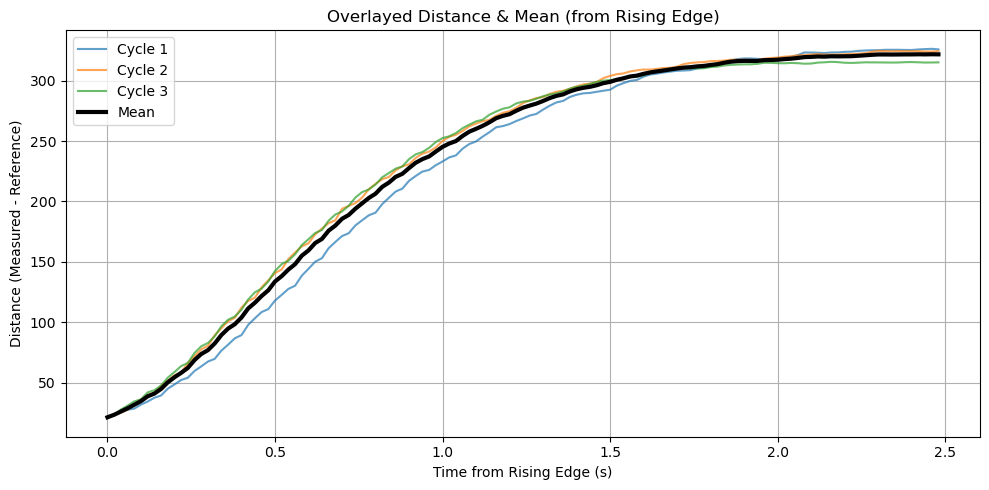

In [16]:
import numpy as np
import matplotlib.pyplot as plt

df_g1 = group_data['group4']
ref_x = df_g1['Reference Position X'].values
ref_y = df_g1['Reference Position Y'].values
act_x = df_g1['Measured Position X'].values
act_y = df_g1['Measured Position Y'].values
sample_rate = 50
time = np.arange(len(df_g1)) / sample_rate

distance = np.sqrt((act_x - ref_x)**2 + (act_y - ref_y)**2)

# 1. 기준선(임계값) crossing 방식: 예를 들어 distance > 50이 되는 순간
threshold = 20
logic = distance > threshold

# rising edge 찾기: False→True가 되는 순간의 인덱스
rising_starts = np.where((~logic[:-1]) & (logic[1:]))[0] + 1

# 충분히 떨어진 시작점만 유지 (너무 가까운 연속 구간 필터링)
min_gap = sample_rate * 5  # 최소 4초 이상 간격
rising_start_filtered = [rising_starts[0]]
for idx in rising_starts[1:]:
    if idx - rising_start_filtered[-1] > min_gap:
        rising_start_filtered.append(idx)
rising_start_filtered = np.array(rising_start_filtered)[:3]  # 3개만

plt.figure(figsize=(12,5))
plt.plot(time, distance, label='Measured-Reference Distance')
plt.scatter(time[rising_start_filtered], distance[rising_start_filtered], color='red', zorder=5, label='Rising Start (true)')
plt.xlabel('Time (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Measured vs Reference Position Distance (Group 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# --- 파라미터: 보여줄 구간 (초 단위로 원하는 만큼) ---
window_sec = 2.5  # 예: 6초간 보여주기 (여기만 바꾸세요!)
window_len = int(window_sec * sample_rate)

# --- 빨간 점(rising start)에서부터 구간 잘라서 저장 ---
stacked = []
for start in rising_start_filtered:
    if start + window_len <= len(distance):
        stacked.append(distance[start : start + window_len])
stacked = np.array(stacked)  # (사이클 수, window 길이)

# --- 평균 곡선 ---
mean_curve = np.mean(stacked, axis=0)
time_aligned = np.arange(window_len) / sample_rate

# --- 플롯 ---
plt.figure(figsize=(10,5))
for i, cycle in enumerate(stacked, 1):
    plt.plot(time_aligned, cycle, alpha=0.7, label=f'Cycle {i}')
plt.plot(time_aligned, mean_curve, color='k', linewidth=3, label='Mean', zorder=10)
plt.xlabel('Time from Rising Edge (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Overlayed Distance & Mean (from Rising Edge)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
from scipy.stats import linregress

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        y = distance[start : start+window_len]
        t = np.arange(window_len) / sample_rate  # 시간축
        slope, intercept, r_value, p_value, std_err = linregress(t, y)
        print(f"Cycle {i+1} | 기울기 = {slope:.5f} m/s (R²={r_value**2:.3f})")


Cycle 1 | 기울기 = 131.85543 m/s (R²=0.893)
Cycle 2 | 기울기 = 123.91268 m/s (R²=0.856)
Cycle 3 | 기울기 = 119.22740 m/s (R²=0.836)


In [18]:
# window_len: 보여준 구간 샘플수 (이전 셀에서 그대로 사용)
duration_sec = window_len / sample_rate   # 실제로 보여준 시간(초)
delta_F = 4 * 9.81                       # 하중 변화량 (N)

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        x0 = distance[start]
        x1 = distance[start + window_len - 1]
        delta_x = x1 - x0
        if abs(delta_x) > 1e-6:
            K_global = delta_F / delta_x
            print(f"Cycle {i+1} | Δx_total = {delta_x:.4f}m, 평균 K = {K_global:.2f} N/m")
        else:
            print(f"Cycle {i+1} | Δx 너무 작음, K 계산 불가")


Cycle 1 | Δx_total = 305.4470m, 평균 K = 0.13 N/m
Cycle 2 | Δx_total = 302.6978m, 평균 K = 0.13 N/m
Cycle 3 | Δx_total = 293.5636m, 평균 K = 0.13 N/m


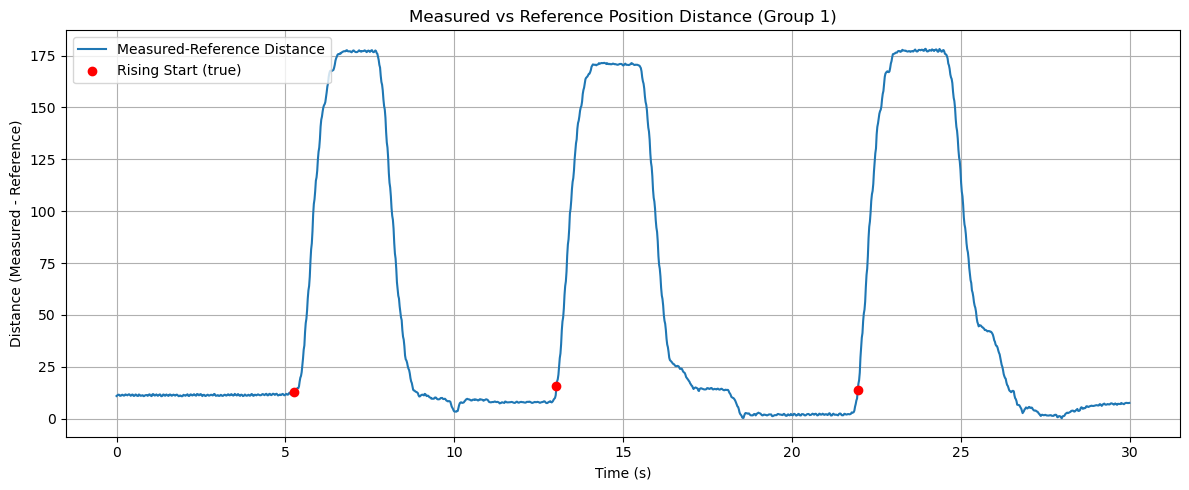

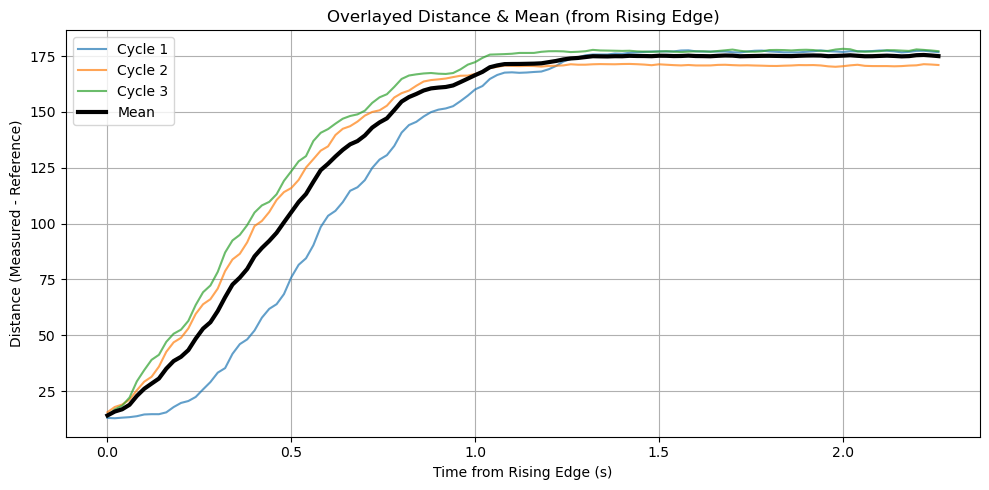

In [19]:
import numpy as np
import matplotlib.pyplot as plt

df_g1 = group_data['group5']
ref_x = df_g1['Reference Position X'].values
ref_y = df_g1['Reference Position Y'].values
act_x = df_g1['Measured Position X'].values
act_y = df_g1['Measured Position Y'].values
sample_rate = 50
time = np.arange(len(df_g1)) / sample_rate

distance = np.sqrt((act_x - ref_x)**2 + (act_y - ref_y)**2)

# 1. 기준선(임계값) crossing 방식: 예를 들어 distance > 50이 되는 순간
threshold = 13
logic = distance > threshold

# rising edge 찾기: False→True가 되는 순간의 인덱스
rising_starts = np.where((~logic[:-1]) & (logic[1:]))[0] + 1

# 충분히 떨어진 시작점만 유지 (너무 가까운 연속 구간 필터링)
min_gap = sample_rate * 5  # 최소 4초 이상 간격
rising_start_filtered = [rising_starts[0]]
for idx in rising_starts[1:]:
    if idx - rising_start_filtered[-1] > min_gap:
        rising_start_filtered.append(idx)
rising_start_filtered = np.array(rising_start_filtered)[:3]  # 3개만

plt.figure(figsize=(12,5))
plt.plot(time, distance, label='Measured-Reference Distance')
plt.scatter(time[rising_start_filtered], distance[rising_start_filtered], color='red', zorder=5, label='Rising Start (true)')
plt.xlabel('Time (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Measured vs Reference Position Distance (Group 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# --- 파라미터: 보여줄 구간 (초 단위로 원하는 만큼) ---
window_sec = 2.3  # 예: 6초간 보여주기 (여기만 바꾸세요!)
window_len = int(window_sec * sample_rate)

# --- 빨간 점(rising start)에서부터 구간 잘라서 저장 ---
stacked = []
for start in rising_start_filtered:
    if start + window_len <= len(distance):
        stacked.append(distance[start : start + window_len])
stacked = np.array(stacked)  # (사이클 수, window 길이)

# --- 평균 곡선 ---
mean_curve = np.mean(stacked, axis=0)
time_aligned = np.arange(window_len) / sample_rate

# --- 플롯 ---
plt.figure(figsize=(10,5))
for i, cycle in enumerate(stacked, 1):
    plt.plot(time_aligned, cycle, alpha=0.7, label=f'Cycle {i}')
plt.plot(time_aligned, mean_curve, color='k', linewidth=3, label='Mean', zorder=10)
plt.xlabel('Time from Rising Edge (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Overlayed Distance & Mean (from Rising Edge)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
from scipy.stats import linregress

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        y = distance[start : start+window_len]
        t = np.arange(window_len) / sample_rate  # 시간축
        slope, intercept, r_value, p_value, std_err = linregress(t, y)
        print(f"Cycle {i+1} | 기울기 = {slope:.5f} m/s (R²={r_value**2:.3f})")


Cycle 1 | 기울기 = 79.35789 m/s (R²=0.778)
Cycle 2 | 기울기 = 57.32767 m/s (R²=0.650)
Cycle 3 | 기울기 = 58.57726 m/s (R²=0.657)


In [21]:
# window_len: 보여준 구간 샘플수 (이전 셀에서 그대로 사용)
duration_sec = window_len / sample_rate   # 실제로 보여준 시간(초)
delta_F = 4 * 9.81                       # 하중 변화량 (N)

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        x0 = distance[start]
        x1 = distance[start + window_len - 1]
        delta_x = x1 - x0
        if abs(delta_x) > 1e-6:
            K_global = delta_F / delta_x
            print(f"Cycle {i+1} | Δx_total = {delta_x:.4f}m, 평균 K = {K_global:.2f} N/m")
        else:
            print(f"Cycle {i+1} | Δx 너무 작음, K 계산 불가")


Cycle 1 | Δx_total = 163.7305m, 평균 K = 0.24 N/m
Cycle 2 | Δx_total = 155.4176m, 평균 K = 0.25 N/m
Cycle 3 | Δx_total = 163.4035m, 평균 K = 0.24 N/m


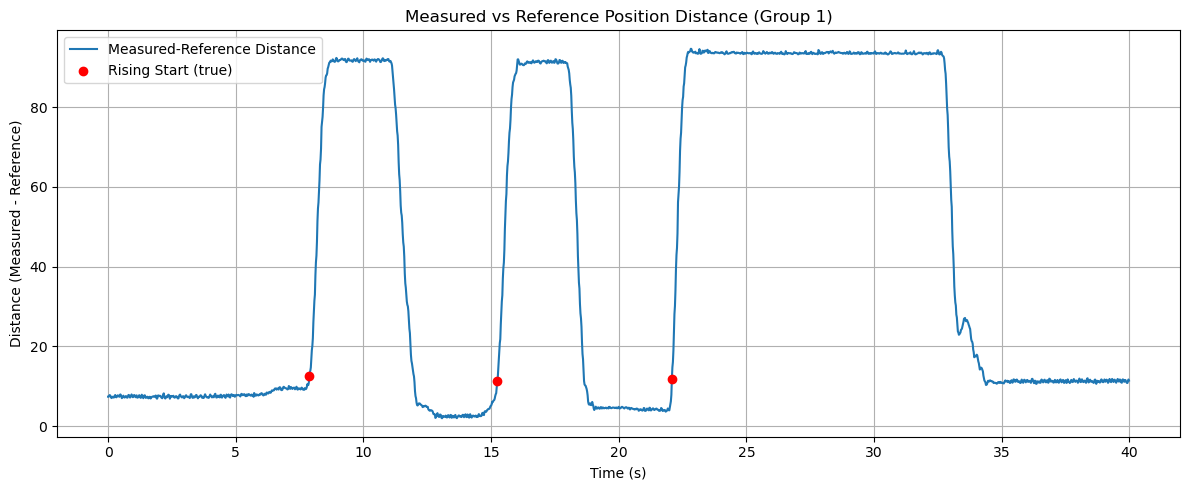

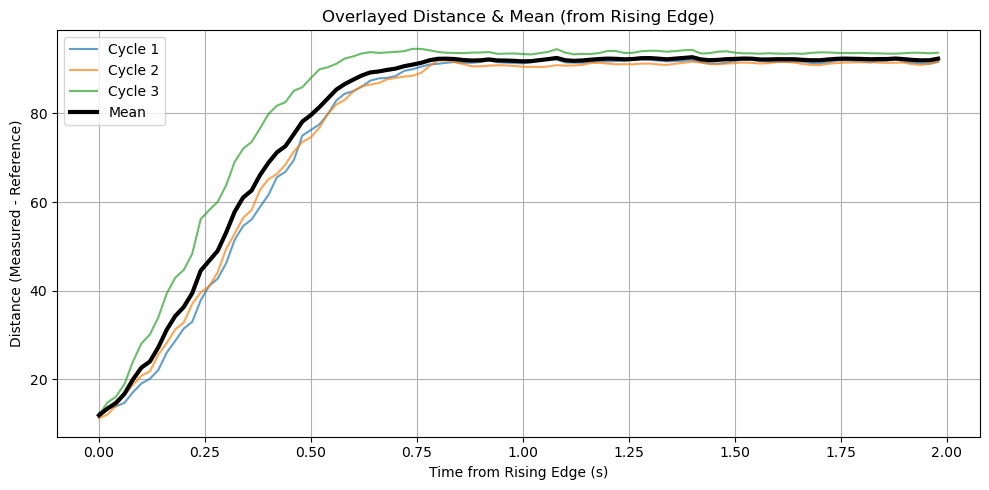

In [22]:
import numpy as np
import matplotlib.pyplot as plt

df_g1 = group_data['group6']
ref_x = df_g1['Reference Position X'].values
ref_y = df_g1['Reference Position Y'].values
act_x = df_g1['Measured Position X'].values
act_y = df_g1['Measured Position Y'].values
sample_rate = 50
time = np.arange(len(df_g1)) / sample_rate

distance = np.sqrt((act_x - ref_x)**2 + (act_y - ref_y)**2)

# 1. 기준선(임계값) crossing 방식: 예를 들어 distance > 50이 되는 순간
threshold = 11
logic = distance > threshold

# rising edge 찾기: False→True가 되는 순간의 인덱스
rising_starts = np.where((~logic[:-1]) & (logic[1:]))[0] + 1

# 충분히 떨어진 시작점만 유지 (너무 가까운 연속 구간 필터링)
min_gap = sample_rate * 5  # 최소 4초 이상 간격
rising_start_filtered = [rising_starts[0]]
for idx in rising_starts[1:]:
    if idx - rising_start_filtered[-1] > min_gap:
        rising_start_filtered.append(idx)
rising_start_filtered = np.array(rising_start_filtered)[:3]  # 3개만

plt.figure(figsize=(12,5))
plt.plot(time, distance, label='Measured-Reference Distance')
plt.scatter(time[rising_start_filtered], distance[rising_start_filtered], color='red', zorder=5, label='Rising Start (true)')
plt.xlabel('Time (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Measured vs Reference Position Distance (Group 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# --- 파라미터: 보여줄 구간 (초 단위로 원하는 만큼) ---
window_sec = 2  # 예: 6초간 보여주기 (여기만 바꾸세요!)
window_len = int(window_sec * sample_rate)

# --- 빨간 점(rising start)에서부터 구간 잘라서 저장 ---
stacked = []
for start in rising_start_filtered:
    if start + window_len <= len(distance):
        stacked.append(distance[start : start + window_len])
stacked = np.array(stacked)  # (사이클 수, window 길이)

# --- 평균 곡선 ---
mean_curve = np.mean(stacked, axis=0)
time_aligned = np.arange(window_len) / sample_rate

# --- 플롯 ---
plt.figure(figsize=(10,5))
for i, cycle in enumerate(stacked, 1):
    plt.plot(time_aligned, cycle, alpha=0.7, label=f'Cycle {i}')
plt.plot(time_aligned, mean_curve, color='k', linewidth=3, label='Mean', zorder=10)
plt.xlabel('Time from Rising Edge (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Overlayed Distance & Mean (from Rising Edge)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
from scipy.stats import linregress

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        y = distance[start : start+window_len]
        t = np.arange(window_len) / sample_rate  # 시간축
        slope, intercept, r_value, p_value, std_err = linregress(t, y)
        print(f"Cycle {i+1} | 기울기 = {slope:.5f} m/s (R²={r_value**2:.3f})")


Cycle 1 | 기울기 = 32.80295 m/s (R²=0.598)
Cycle 2 | 기울기 = 31.77563 m/s (R²=0.599)
Cycle 3 | 기울기 = 26.32278 m/s (R²=0.489)


In [24]:
# window_len: 보여준 구간 샘플수 (이전 셀에서 그대로 사용)
duration_sec = window_len / sample_rate   # 실제로 보여준 시간(초)
delta_F = 4 * 9.81                       # 하중 변화량 (N)

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        x0 = distance[start]
        x1 = distance[start + window_len - 1]
        delta_x = x1 - x0
        if abs(delta_x) > 1e-6:
            K_global = delta_F / delta_x
            print(f"Cycle {i+1} | Δx_total = {delta_x:.4f}m, 평균 K = {K_global:.2f} N/m")
        else:
            print(f"Cycle {i+1} | Δx 너무 작음, K 계산 불가")


Cycle 1 | Δx_total = 79.1618m, 평균 K = 0.50 N/m
Cycle 2 | Δx_total = 80.5003m, 평균 K = 0.49 N/m
Cycle 3 | Δx_total = 81.7681m, 평균 K = 0.48 N/m


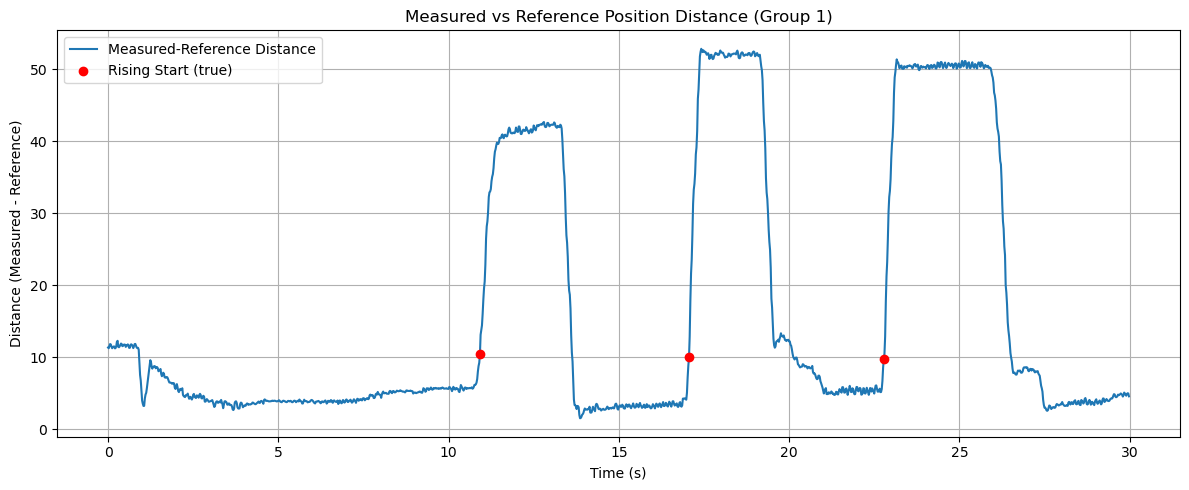

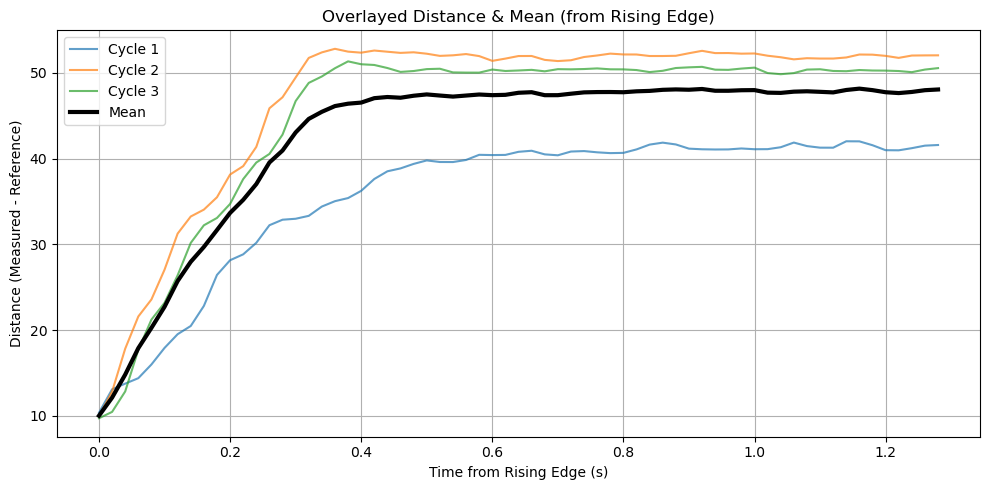

In [25]:
import numpy as np
import matplotlib.pyplot as plt

df_g1 = group_data['group7']
ref_x = df_g1['Reference Position X'].values
ref_y = df_g1['Reference Position Y'].values
act_x = df_g1['Measured Position X'].values
act_y = df_g1['Measured Position Y'].values
sample_rate = 50
time = np.arange(len(df_g1)) / sample_rate

distance = np.sqrt((act_x - ref_x)**2 + (act_y - ref_y)**2)

# 1. 기준선(임계값) crossing 방식: 예를 들어 distance > 50이 되는 순간
threshold = 9.7
logic = distance > threshold

# rising edge 찾기: False→True가 되는 순간의 인덱스
rising_starts = np.where((~logic[:-1]) & (logic[1:]))[0] + 1

# 충분히 떨어진 시작점만 유지 (너무 가까운 연속 구간 필터링)
min_gap = sample_rate * 5  # 최소 4초 이상 간격
rising_start_filtered = [rising_starts[0]]
for idx in rising_starts[1:]:
    if idx - rising_start_filtered[-1] > min_gap:
        rising_start_filtered.append(idx)
rising_start_filtered = np.array(rising_start_filtered)[:3]  # 3개만

plt.figure(figsize=(12,5))
plt.plot(time, distance, label='Measured-Reference Distance')
plt.scatter(time[rising_start_filtered], distance[rising_start_filtered], color='red', zorder=5, label='Rising Start (true)')
plt.xlabel('Time (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Measured vs Reference Position Distance (Group 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# --- 파라미터: 보여줄 구간 (초 단위로 원하는 만큼) ---
window_sec = 1.3  # 예: 6초간 보여주기 (여기만 바꾸세요!)
window_len = int(window_sec * sample_rate)

# --- 빨간 점(rising start)에서부터 구간 잘라서 저장 ---
stacked = []
for start in rising_start_filtered:
    if start + window_len <= len(distance):
        stacked.append(distance[start : start + window_len])
stacked = np.array(stacked)  # (사이클 수, window 길이)

# --- 평균 곡선 ---
mean_curve = np.mean(stacked, axis=0)
time_aligned = np.arange(window_len) / sample_rate

# --- 플롯 ---
plt.figure(figsize=(10,5))
for i, cycle in enumerate(stacked, 1):
    plt.plot(time_aligned, cycle, alpha=0.7, label=f'Cycle {i}')
plt.plot(time_aligned, mean_curve, color='k', linewidth=3, label='Mean', zorder=10)
plt.xlabel('Time from Rising Edge (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Overlayed Distance & Mean (from Rising Edge)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
from scipy.stats import linregress

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        y = distance[start : start+window_len]
        t = np.arange(window_len) / sample_rate  # 시간축
        slope, intercept, r_value, p_value, std_err = linregress(t, y)
        print(f"Cycle {i+1} | 기울기 = {slope:.5f} m/s (R²={r_value**2:.3f})")


Cycle 1 | 기울기 = 18.66947 m/s (R²=0.655)
Cycle 2 | 기울기 = 19.09162 m/s (R²=0.467)
Cycle 3 | 기울기 = 20.35534 m/s (R²=0.490)


In [27]:
# window_len: 보여준 구간 샘플수 (이전 셀에서 그대로 사용)
duration_sec = window_len / sample_rate   # 실제로 보여준 시간(초)
delta_F = 4 * 9.81                       # 하중 변화량 (N)

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        x0 = distance[start]
        x1 = distance[start + window_len - 1]
        delta_x = x1 - x0
        if abs(delta_x) > 1e-6:
            K_global = delta_F / delta_x
            print(f"Cycle {i+1} | Δx_total = {delta_x:.4f}m, 평균 K = {K_global:.2f} N/m")
        else:
            print(f"Cycle {i+1} | Δx 너무 작음, K 계산 불가")


Cycle 1 | Δx_total = 31.2190m, 평균 K = 1.26 N/m
Cycle 2 | Δx_total = 42.0669m, 평균 K = 0.93 N/m
Cycle 3 | Δx_total = 40.8222m, 평균 K = 0.96 N/m


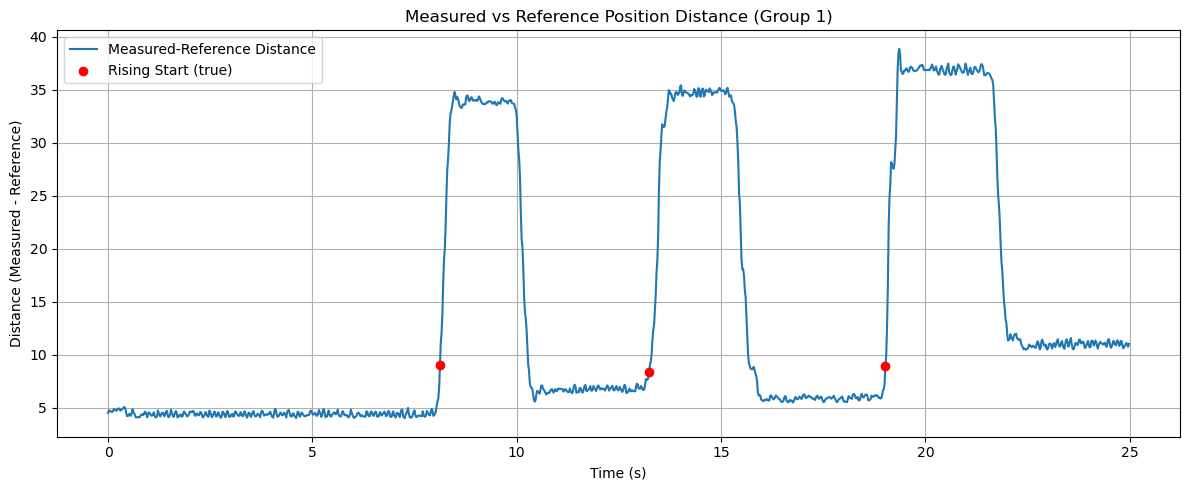

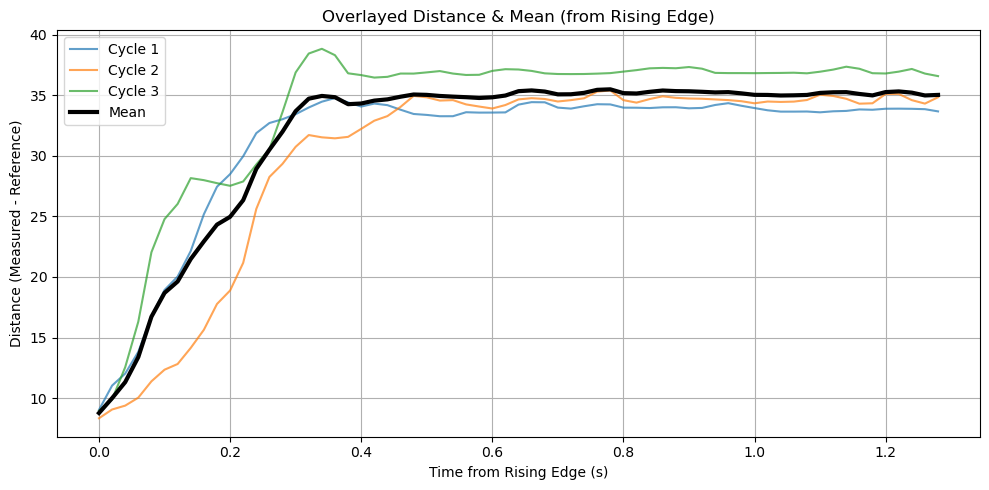

In [28]:
import numpy as np
import matplotlib.pyplot as plt

df_g1 = group_data['group8']
ref_x = df_g1['Reference Position X'].values
ref_y = df_g1['Reference Position Y'].values
act_x = df_g1['Measured Position X'].values
act_y = df_g1['Measured Position Y'].values
sample_rate = 50
time = np.arange(len(df_g1)) / sample_rate

distance = np.sqrt((act_x - ref_x)**2 + (act_y - ref_y)**2)

# 1. 기준선(임계값) crossing 방식: 예를 들어 distance > 50이 되는 순간
threshold = 8
logic = distance > threshold

# rising edge 찾기: False→True가 되는 순간의 인덱스
rising_starts = np.where((~logic[:-1]) & (logic[1:]))[0] + 1

# 충분히 떨어진 시작점만 유지 (너무 가까운 연속 구간 필터링)
min_gap = sample_rate * 5  # 최소 4초 이상 간격
rising_start_filtered = [rising_starts[0]]
for idx in rising_starts[1:]:
    if idx - rising_start_filtered[-1] > min_gap:
        rising_start_filtered.append(idx)
rising_start_filtered = np.array(rising_start_filtered)[:3]  # 3개만

plt.figure(figsize=(12,5))
plt.plot(time, distance, label='Measured-Reference Distance')
plt.scatter(time[rising_start_filtered], distance[rising_start_filtered], color='red', zorder=5, label='Rising Start (true)')
plt.xlabel('Time (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Measured vs Reference Position Distance (Group 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# --- 파라미터: 보여줄 구간 (초 단위로 원하는 만큼) ---
window_sec = 1.3  # 예: 6초간 보여주기 (여기만 바꾸세요!)
window_len = int(window_sec * sample_rate)

# --- 빨간 점(rising start)에서부터 구간 잘라서 저장 ---
stacked = []
for start in rising_start_filtered:
    if start + window_len <= len(distance):
        stacked.append(distance[start : start + window_len])
stacked = np.array(stacked)  # (사이클 수, window 길이)

# --- 평균 곡선 ---
mean_curve = np.mean(stacked, axis=0)
time_aligned = np.arange(window_len) / sample_rate

# --- 플롯 ---
plt.figure(figsize=(10,5))
for i, cycle in enumerate(stacked, 1):
    plt.plot(time_aligned, cycle, alpha=0.7, label=f'Cycle {i}')
plt.plot(time_aligned, mean_curve, color='k', linewidth=3, label='Mean', zorder=10)
plt.xlabel('Time from Rising Edge (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Overlayed Distance & Mean (from Rising Edge)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
from scipy.stats import linregress

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        y = distance[start : start+window_len]
        t = np.arange(window_len) / sample_rate  # 시간축
        slope, intercept, r_value, p_value, std_err = linregress(t, y)
        print(f"Cycle {i+1} | 기울기 = {slope:.5f} m/s (R²={r_value**2:.3f})")


Cycle 1 | 기울기 = 10.69224 m/s (R²=0.406)
Cycle 2 | 기울기 = 16.71491 m/s (R²=0.573)
Cycle 3 | 기울기 = 11.86580 m/s (R²=0.435)


In [30]:
# window_len: 보여준 구간 샘플수 (이전 셀에서 그대로 사용)
duration_sec = window_len / sample_rate   # 실제로 보여준 시간(초)
delta_F = 4 * 9.81                       # 하중 변화량 (N)

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        x0 = distance[start]
        x1 = distance[start + window_len - 1]
        delta_x = x1 - x0
        if abs(delta_x) > 1e-6:
            K_global = delta_F / delta_x
            print(f"Cycle {i+1} | Δx_total = {delta_x:.4f}m, 평균 K = {K_global:.2f} N/m")
        else:
            print(f"Cycle {i+1} | Δx 너무 작음, K 계산 불가")


Cycle 1 | Δx_total = 24.6674m, 평균 K = 1.59 N/m
Cycle 2 | Δx_total = 26.5251m, 평균 K = 1.48 N/m
Cycle 3 | Δx_total = 27.6631m, 평균 K = 1.42 N/m


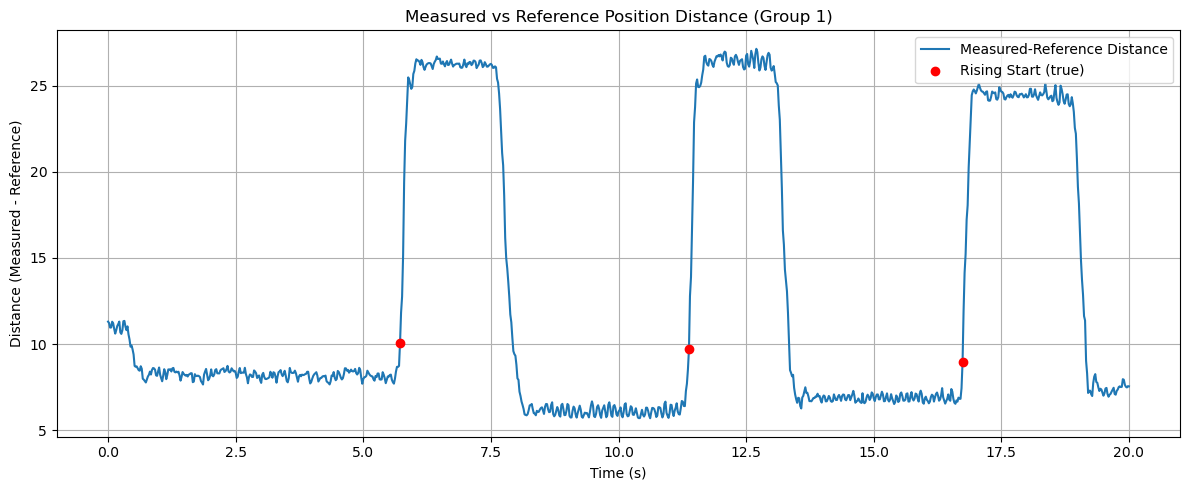

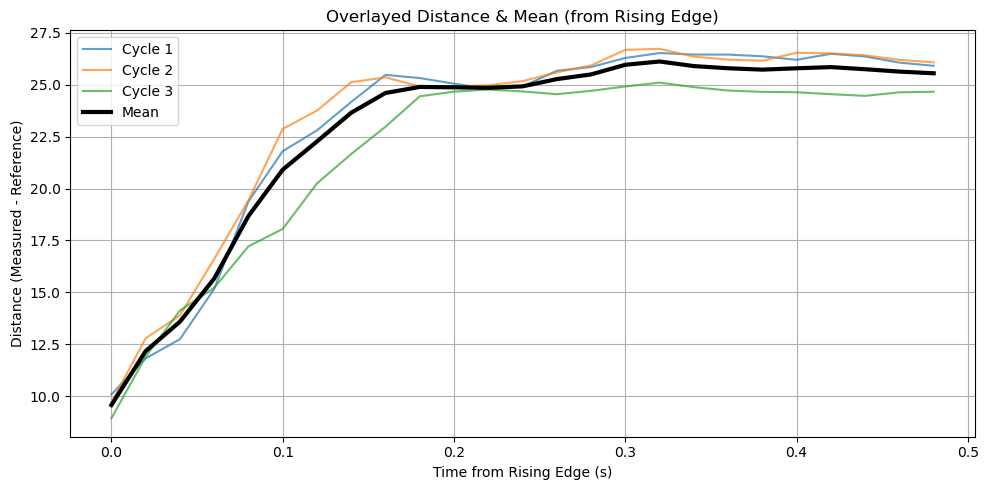

In [31]:
import numpy as np
import matplotlib.pyplot as plt

df_g1 = group_data['group9']
ref_x = df_g1['Reference Position X'].values
ref_y = df_g1['Reference Position Y'].values
act_x = df_g1['Measured Position X'].values
act_y = df_g1['Measured Position Y'].values
sample_rate = 50
time = np.arange(len(df_g1)) / sample_rate

distance = np.sqrt((act_x - ref_x)**2 + (act_y - ref_y)**2)

# 1. 기준선(임계값) crossing 방식: 예를 들어 distance > 50이 되는 순간
threshold = 8.75
logic = distance > threshold

# rising edge 찾기: False→True가 되는 순간의 인덱스
rising_starts = np.where((~logic[:-1]) & (logic[1:]))[0] + 1

# 충분히 떨어진 시작점만 유지 (너무 가까운 연속 구간 필터링)
min_gap = sample_rate * 5  # 최소 4초 이상 간격
rising_start_filtered = [rising_starts[0]]
for idx in rising_starts[1:]:
    if idx - rising_start_filtered[-1] > min_gap:
        rising_start_filtered.append(idx)
rising_start_filtered = np.array(rising_start_filtered)[:3]  # 3개만

plt.figure(figsize=(12,5))
plt.plot(time, distance, label='Measured-Reference Distance')
plt.scatter(time[rising_start_filtered], distance[rising_start_filtered], color='red', zorder=5, label='Rising Start (true)')
plt.xlabel('Time (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Measured vs Reference Position Distance (Group 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# --- 파라미터: 보여줄 구간 (초 단위로 원하는 만큼) ---
window_sec = 0.5  # 예: 6초간 보여주기 (여기만 바꾸세요!)
window_len = int(window_sec * sample_rate)

# --- 빨간 점(rising start)에서부터 구간 잘라서 저장 ---
stacked = []
for start in rising_start_filtered:
    if start + window_len <= len(distance):
        stacked.append(distance[start : start + window_len])
stacked = np.array(stacked)  # (사이클 수, window 길이)

# --- 평균 곡선 ---
mean_curve = np.mean(stacked, axis=0)
time_aligned = np.arange(window_len) / sample_rate

# --- 플롯 ---
plt.figure(figsize=(10,5))
for i, cycle in enumerate(stacked, 1):
    plt.plot(time_aligned, cycle, alpha=0.7, label=f'Cycle {i}')
plt.plot(time_aligned, mean_curve, color='k', linewidth=3, label='Mean', zorder=10)
plt.xlabel('Time from Rising Edge (s)')
plt.ylabel('Distance (Measured - Reference)')
plt.title('Overlayed Distance & Mean (from Rising Edge)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
from scipy.stats import linregress

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        y = distance[start : start+window_len]
        t = np.arange(window_len) / sample_rate  # 시간축
        slope, intercept, r_value, p_value, std_err = linregress(t, y)
        print(f"Cycle {i+1} | 기울기 = {slope:.5f} m/s (R²={r_value**2:.3f})")


Cycle 1 | 기울기 = 27.45873 m/s (R²=0.631)
Cycle 2 | 기울기 = 25.86076 m/s (R²=0.610)
Cycle 3 | 기울기 = 25.92937 m/s (R²=0.650)


In [33]:
# window_len: 보여준 구간 샘플수 (이전 셀에서 그대로 사용)
duration_sec = window_len / sample_rate   # 실제로 보여준 시간(초)
delta_F = 4 * 9.81                       # 하중 변화량 (N)

for i, start in enumerate(rising_start_filtered):
    if start + window_len <= len(distance):
        x0 = distance[start]
        x1 = distance[start + window_len - 1]
        delta_x = x1 - x0
        if abs(delta_x) > 1e-6:
            K_global = delta_F / delta_x
            print(f"Cycle {i+1} | Δx_total = {delta_x:.4f}m, 평균 K = {K_global:.2f} N/m")
        else:
            print(f"Cycle {i+1} | Δx 너무 작음, K 계산 불가")


Cycle 1 | Δx_total = 15.8215m, 평균 K = 2.48 N/m
Cycle 2 | Δx_total = 16.3758m, 평균 K = 2.40 N/m
Cycle 3 | Δx_total = 15.7201m, 평균 K = 2.50 N/m


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 1. 그룹별 파라미터를 딕셔너리로 선언
group_params = {
    'group1': {'threshold': 20,  'window_sec': 1.0, 'transient_sec': None},
    'group2': {'threshold': 20,  'window_sec': 1.5, 'transient_sec': None},
    'group3': {'threshold': 20,  'window_sec': 1.5, 'transient_sec': None},
    'group4': {'threshold': 20,  'window_sec': 2.5, 'transient_sec': 0.6},
    'group5': {'threshold': 13,  'window_sec': 2.3, 'transient_sec': 0.5},
    'group6': {'threshold': 11,  'window_sec': 2.0, 'transient_sec': 0.4},
    'group7': {'threshold': 9.7, 'window_sec': 1.3, 'transient_sec': 0.3},
    'group8': {'threshold': 8,   'window_sec': 1.3, 'transient_sec': 0.2},
    'group9': {'threshold': 8.75,'window_sec': 0.5, 'transient_sec': 0.1},
}
sample_rate = 50
mass_kg = 4
delta_F = mass_kg * 9.81  # N

def analyze_group(df, threshold, window_sec, transient_sec, sample_rate=50, plot=True, group_name=""):
    # mm 단위로 변환
    ref_x = df['Reference Position X'].values
    ref_y = df['Reference Position Y'].values
    act_x = df['Measured Position X'].values
    act_y = df['Measured Position Y'].values
    time = np.arange(len(df)) / sample_rate

    distance = np.sqrt((act_x - ref_x)**2 + (act_y - ref_y)**2)  # mm

    logic = distance > threshold
    rising_starts = np.where((~logic[:-1]) & (logic[1:]))[0] + 1
    min_gap = int(sample_rate * 5)
    if len(rising_starts) == 0:
        return None
    rising_start_filtered = [rising_starts[0]]
    for idx in rising_starts[1:]:
        if idx - rising_start_filtered[-1] > min_gap:
            rising_start_filtered.append(idx)
    rising_start_filtered = np.array(rising_start_filtered)[:3]

    window_len = int(window_sec * sample_rate)

    slopes, slope_R2s, K_means, delta_xs = [], [], [], []
    stacked = []
    for start in rising_start_filtered:
        if start + window_len <= len(distance):
            y = distance[start : start + window_len]
            t = np.arange(window_len) / sample_rate
            stacked.append(y)

            # 비수렴 그룹(1~3)은 전체 window, 수렴 그룹은 transient만
            if transient_sec is not None:
                transient_len = int(transient_sec * sample_rate)
                y_fit = y[:transient_len]
                t_fit = t[:transient_len]
            else:
                y_fit = y
                t_fit = t

            slope, intercept, r_value, p_value, std_err = linregress(t_fit, y_fit)
            slopes.append(slope)
            slope_R2s.append(r_value ** 2)

            delta_x = y[-1] - y[0]
            delta_xs.append(delta_x)
            if group_name in ['group1', 'group2', 'group3']:
                K = np.nan
            else:
                K = delta_F / delta_x if abs(delta_x) > 1e-6 else np.nan
            K_means.append(K)

    if not stacked:
        return None

    stacked = np.array(stacked)
    mean_curve = np.mean(stacked, axis=0)
    time_aligned = np.arange(window_len) / sample_rate

    if plot:
        plt.figure(figsize=(9,4))
        for i, cycle in enumerate(stacked, 1):
            plt.plot(time_aligned, cycle, alpha=0.6, label=f'Cycle {i}')
        plt.plot(time_aligned, mean_curve, color='k', linewidth=2, label='Mean', zorder=10)
        plt.xlabel('Time from Rising Edge (s)')
        plt.ylabel('Distance (Measured - Reference) [mm]')
        plt.title(f'{group_name}: Overlayed Distance & Mean')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # group1~3은 mean_K, std_K, mean_delta_x, std_delta_x를 NaN으로!
    if group_name in ['group1', 'group2', 'group3']:
        mean_K = np.nan
        std_K = np.nan
        mean_delta_x = np.nan
        std_delta_x = np.nan
    else:
        mean_K = np.nanmean(K_means)
        std_K = np.nanstd(K_means)
        mean_delta_x = np.nanmean(delta_xs)
        std_delta_x = np.nanstd(delta_xs)

    return {
        'group': group_name,
        'n_cycles': len(stacked),
        'mean_slope (mm/s)': np.nanmean(slopes),
        'std_slope': np.nanstd(slopes),
        'mean_slope_R2': np.nanmean(slope_R2s),
        'mean_K (N/mm)': mean_K,
        'std_K': std_K,
        'mean_delta_x (mm)': mean_delta_x,
        'std_delta_x': std_delta_x
    }


# 2. 전체 그룹 loop & 분석
all_results = []
for group_name, params in group_params.items():
    df = group_data[group_name]
    res = analyze_group(
        df,
        threshold=params['threshold'],
        window_sec=params['window_sec'],
        transient_sec=params['transient_sec'],
        sample_rate=sample_rate,
        plot=False,
        group_name=group_name
    )
    if res is not None:
        all_results.append(res)

# 3. 결과 표로 보기
df_results = pd.DataFrame(all_results)
print(df_results)


    group  n_cycles  mean_slope (mm/s)  std_slope  mean_slope_R2  \
0  group1         3         371.279202   9.338966       0.992024   
1  group2         3         334.302348   9.560830       0.993975   
2  group3         3         306.488828   4.308157       0.996784   
3  group4         3         238.287116  21.989187       0.988313   
4  group5         3         188.791197  48.648550       0.961826   
5  group6         3         149.223765  21.731624       0.986908   
6  group7         3         111.288572  19.524430       0.981254   
7  group8         3          91.617742  30.826494       0.955603   
8  group9         3         108.464573   7.006187       0.962207   

   mean_K (N/mm)     std_K  mean_delta_x (mm)  std_delta_x  
0            NaN       NaN                NaN          NaN  
1            NaN       NaN                NaN          NaN  
2            NaN       NaN                NaN          NaN  
3       0.130590  0.002228         300.569438     5.079444  
4       0.2440

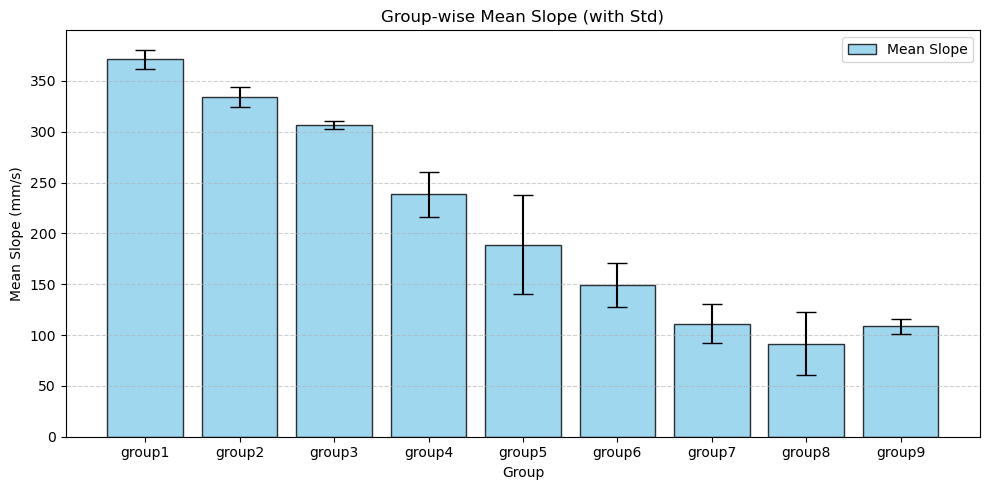

In [35]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = df_results['group']
y_slopes = df_results['mean_slope (mm/s)']
y_err = df_results['std_slope']

x = np.arange(len(x_labels))

plt.figure(figsize=(10,5))
bars = plt.bar(x, y_slopes, yerr=y_err, capsize=7, alpha=0.8, color='skyblue', edgecolor='k', label='Mean Slope')
plt.xticks(x, x_labels)
plt.xlabel('Group')
plt.ylabel('Mean Slope (mm/s)')
plt.title('Group-wise Mean Slope (with Std)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


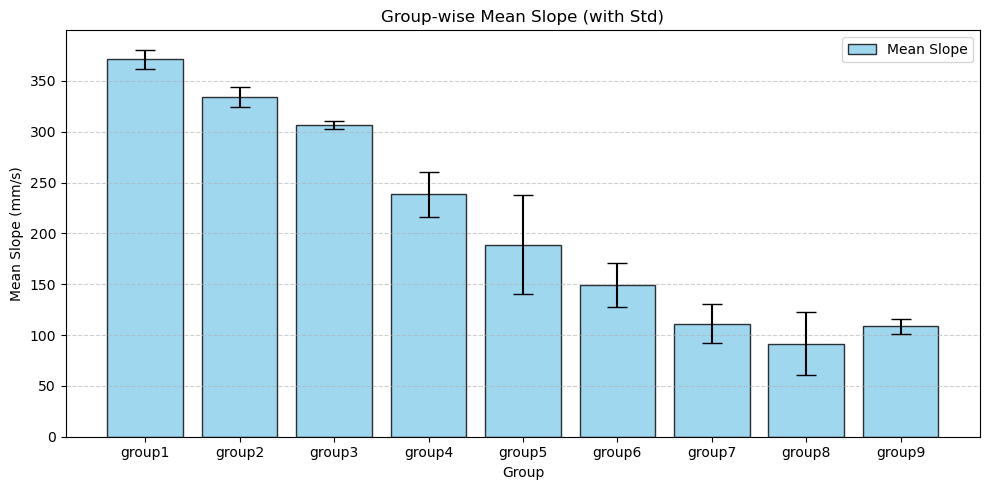

In [36]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = df_results['group']
y_slopes = df_results['mean_slope (mm/s)']
y_err = df_results['std_slope']

x = np.arange(len(x_labels))

plt.figure(figsize=(10,5))
bars = plt.bar(x, y_slopes, yerr=y_err, capsize=7, alpha=0.8, color='skyblue', edgecolor='k', label='Mean Slope')
plt.xticks(x, x_labels)
plt.xlabel('Group')
plt.ylabel('Mean Slope (mm/s)')
plt.title('Group-wise Mean Slope (with Std)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


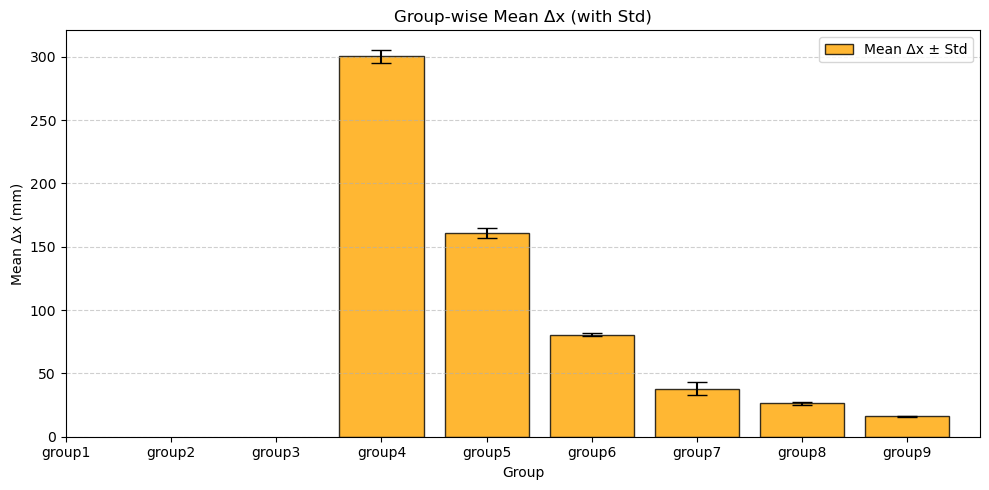

In [37]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = df_results['group']
y_delta_x = df_results['mean_delta_x (mm)']
y_err = df_results['std_delta_x']   # std_delta_x 컬럼이 df_results에 꼭 있어야 합니다!

x = np.arange(len(x_labels))

plt.figure(figsize=(10,5))
bars = plt.bar(
    x, y_delta_x, yerr=y_err,
    capsize=7, alpha=0.8,
    color='orange', edgecolor='k', label='Mean Δx ± Std'
)
plt.xticks(x, x_labels)
plt.xlabel('Group')
plt.ylabel('Mean Δx (mm)')
plt.title('Group-wise Mean Δx (with Std)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


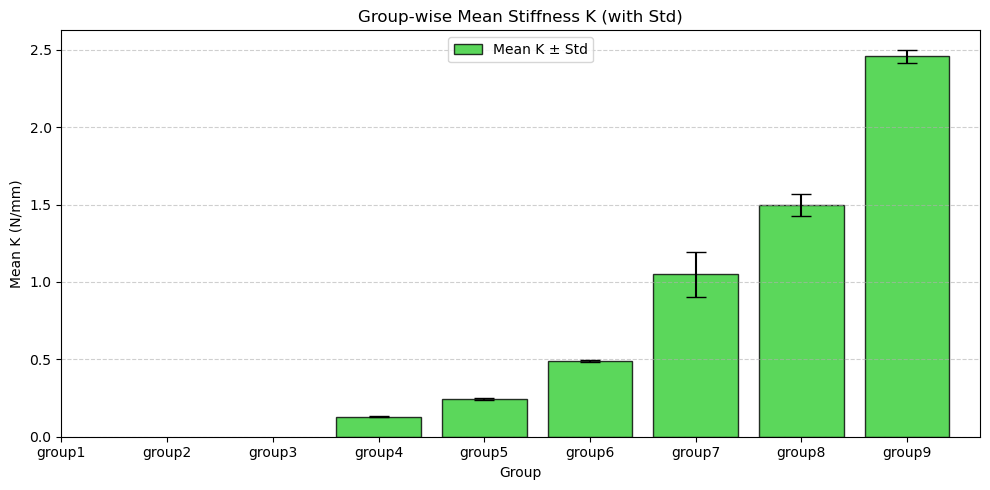

In [38]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = df_results['group']
y_K = df_results['mean_K (N/mm)']
y_err_K = df_results['std_K']

x = np.arange(len(x_labels))

plt.figure(figsize=(10,5))
bars = plt.bar(
    x, y_K, yerr=y_err_K,
    capsize=7, alpha=0.8,
    color='limegreen', edgecolor='k', label='Mean K ± Std'
)
plt.xticks(x, x_labels)
plt.xlabel('Group')
plt.ylabel('Mean K (N/mm)')
plt.title('Group-wise Mean Stiffness K (with Std)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = df_results['group']
y_K = df_results['mean_K (N/mm)']
y_err_K = df_results['std_K']

x = np.arange(len(x_labels))

plt.figure(figsize=(10,5))
bars = plt.bar(
    x, y_K, yerr=y_err_K,
    capsize=7, alpha=0.8,
    color='limegreen', edgecolor='k', label='Mean K ± Std'
)
plt.xticks(x, x_labels)
plt.xlabel('Group')
plt.ylabel('Mean K (N/mm)')
plt.title('Group-wise Mean Stiffness K (with Std)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
